In [20]:
# Spring 2026 Capstone
# William Carroll
# Jessica Brown
# Sydney Halupa

# 1) Install required packages
!pip install -q pydicom scikit-learn scikit-image opencv-python pillow joblib pandas numpy kaggle

# 2) Upload kaggle.json
from google.colab import files
uploaded = files.upload()

# 3) Move kaggle.json into the correct Kaggle config folder
!mkdir -p /root/.kaggle
!mv /content/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# 4) Test Kaggle authentication
!kaggle --version
!kaggle competitions list | head -n 5

# 5) Download RSNA Pneumonia Detection Challenge (DICOM)
!rm -rf /content/datasets/rsna
!mkdir -p /content/datasets/rsna

!kaggle competitions download -c rsna-pneumonia-detection-challenge -p /content/datasets/rsna
!unzip -q "/content/datasets/rsna/*.zip" -d /content/datasets/rsna

print("\n Sample RSNA DICOM paths:")
!find /content/datasets/rsna -name "*.dcm" | head -n 10

print("\n RSNA folder contents:")
!ls -lah /content/datasets/rsna | head -n 30

# 6) Download EASY TAMPERED DATASET (Kaggle dataset)
#    Medical Image Tamper Dataset
!rm -rf /content/datasets/medical_tamper
!mkdir -p /content/datasets/medical_tamper

!kaggle datasets download -d sjagadeeshgiet/image-tamper-dataset -p /content/datasets/medical_tamper
!unzip -q "/content/datasets/medical_tamper/*.zip" -d /content/datasets/medical_tamper

print("\n Sample Tampered Dataset files:")
!find /content/datasets/medical_tamper -type f | head -n 30

print("\n Tampered Dataset folder contents:")
!ls -lah /content/datasets/medical_tamper | head -n 50




Saving kaggle.json to kaggle.json
Kaggle API 1.7.4.5
ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3    2026-04-15 23:59:00  Featured         2,207,152 Usd       1535           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection         2026-02-13 23:59:00  Research           200,000 Usd        739           False  
https://www.kaggle.com/competitions/med-gemma-impact-challenge                   2026-02-24 23:59:00  Featured           100,000 Usd         52           False  
100% 3.66G/3.66G [01:06<00:00, 272MB/s]
100% 3.66G/3.66G [01:06<00:00, 59.3MB/s]

 Sample RSNA DICOM paths:
/content/datasets/rsna/stage_

In [21]:
# This section of code is meant to show how much content is within the dataset that was previously downloaded

import os
from glob import glob

rsna_train = glob("/content/datasets/rsna/stage_2_train_images/*.dcm")
rsna_test  = glob("/content/datasets/rsna/stage_2_test_images/*.dcm")

print("RSNA Train DICOM count:", len(rsna_train))
print("RSNA Test  DICOM count:", len(rsna_test))

originals = glob("/content/datasets/medical_tamper/original/**/*.*", recursive=True)
copy_move = glob("/content/datasets/medical_tamper/copy_move/**/*.*", recursive=True)
copy_paste = glob("/content/datasets/medical_tamper/copy_paste/**/*.*", recursive=True)
content_removal = glob("/content/datasets/medical_tamper/content_removal/**/*.*", recursive=True)
text_addition = glob("/content/datasets/medical_tamper/text_addition/**/*.*", recursive=True)

print("\nTamper Dataset counts:")
print("Original:", len(originals))
print("Copy-Move:", len(copy_move))
print("Copy-Paste:", len(copy_paste))
print("Content Removal:", len(content_removal))
print("Text Addition:", len(text_addition))



RSNA Train DICOM count: 26684
RSNA Test  DICOM count: 3000

Tamper Dataset counts:
Original: 2606
Copy-Move: 2606
Copy-Paste: 2606
Content Removal: 2606
Text Addition: 2606


In [22]:
import os
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split

BASE_TAMPER = "/content/datasets/medical_tamper"
OUT_DIR = "/content/splits/tamper"

TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15
RANDOM_SEED = 42

assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-6

def all_images(folder):
    return sorted(
        glob(os.path.join(folder, "**", "*.png"), recursive=True) +
        glob(os.path.join(folder, "**", "*.jpg"), recursive=True) +
        glob(os.path.join(folder, "**", "*.jpeg"), recursive=True)
    )

# Clean originals
clean_paths = all_images(os.path.join(BASE_TAMPER, "original"))

# Tampered folders
tampered_paths = []
for sub in ["copy_move", "copy_paste", "content_removal", "text_addition"]:
    tampered_paths += all_images(os.path.join(BASE_TAMPER, sub))

print("Tamper dataset counts:")
print("  Clean (original):", len(clean_paths))
print("  Tampered:", len(tampered_paths))

if len(clean_paths) == 0 or len(tampered_paths) == 0:
    raise FileNotFoundError("Tamper dataset folders not found or empty. Check /content/datasets/medical_tamper")

# Build dataframe
# This allows me to "label" the files into their respective categories (0 for clean, 1 for tampered)
df = pd.DataFrame({
    "filepath": clean_paths + tampered_paths,
    "label": ([0] * len(clean_paths)) + ([1] * len(tampered_paths))
})

# Split train vs temp
train_df, temp_df = train_test_split(
    df,
    test_size=(1.0 - TRAIN_RATIO),
    random_state=RANDOM_SEED,
    stratify=df["label"]
)

# Split val vs test from temp
val_size_of_temp = VAL_RATIO / (VAL_RATIO + TEST_RATIO)  # 0.5
val_df, test_df = train_test_split(
    temp_df,
    test_size=(1.0 - val_size_of_temp),
    random_state=RANDOM_SEED,
    stratify=temp_df["label"]
)

# Save CSV (again)
train_df = train_df.copy(); train_df["split"] = "train"
val_df   = val_df.copy();   val_df["split"]   = "val"
test_df  = test_df.copy();  test_df["split"]  = "test"

final_df = pd.concat([train_df, val_df, test_df]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
tamper_csv = "/content/tamper_splits.csv"
final_df.to_csv(tamper_csv, index=False)
print("\nSaved:", tamper_csv)

# ---- Rebuild folder structure ----
# Delete old split folder if it exists (fresh rebuild)
import shutil
if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)

def make_symlinks(df_split, split_name):
    for _, row in df_split.iterrows():
        src = row["filepath"]
        label = int(row["label"])
        label_name = "clean" if label == 0 else "tampered"

        out_folder = os.path.join(OUT_DIR, split_name, label_name)
        os.makedirs(out_folder, exist_ok=True)

        fname = os.path.basename(src)
        link_path = os.path.join(out_folder, fname)

        if not os.path.exists(link_path):
            os.symlink(src, link_path)

make_symlinks(train_df, "train")
make_symlinks(val_df, "val")
make_symlinks(test_df, "test")

print("\n Tamper split folders rebuilt at:", OUT_DIR)


!echo "Train clean:" && ls /content/splits/tamper/train/clean | wc -l
!echo "Train tampered:" && ls /content/splits/tamper/train/tampered | wc -l

!echo "Val clean:" && ls /content/splits/tamper/val/clean | wc -l
!echo "Val tampered:" && ls /content/splits/tamper/val/tampered | wc -l

!echo "Test clean:" && ls /content/splits/tamper/test/clean | wc -l
!echo "Test tampered:" && ls /content/splits/tamper/test/tampered | wc -l


Tamper dataset counts:
  Clean (original): 2606
  Tampered: 10424

Saved: /content/tamper_splits.csv

 Tamper split folders rebuilt at: /content/splits/tamper
Train clean:
1824
Train tampered:
7296
Val clean:
391
Val tampered:
1564
Test clean:
391
Test tampered:
1564


In [23]:
# This code block helps me convert my tamper dataset images from PNGs/JPGs into DICOM files (.dcm)

!pip install -q pydicom opencv-python numpy

import os
import cv2
import numpy as np
import pydicom
from pydicom.dataset import FileDataset
from pydicom.uid import ExplicitVRLittleEndian, generate_uid
from datetime import datetime

TAMPER_SPLIT_DIR = "/content/splits/tamper"
TAMPER_DICOM_OUT = "/content/splits/tamper_dicom"  # new output (DICOM)

def png_to_dicom(png_path: str, dicom_out_path: str):
    img = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image: {png_path}")

    # Ensure uint16 for safer DICOM range
    img_u16 = img.astype(np.uint16)

    os.makedirs(os.path.dirname(dicom_out_path), exist_ok=True)

    file_meta = pydicom.dataset.FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = generate_uid()
    file_meta.MediaStorageSOPInstanceUID = generate_uid()
    file_meta.TransferSyntaxUID = ExplicitVRLittleEndian

    ds = FileDataset(dicom_out_path, {}, file_meta=file_meta, preamble=b"\0" * 128)

    # Minimal required DICOM tags
    ds.Modality = "OT"  # Other
    ds.SOPClassUID = file_meta.MediaStorageSOPClassUID
    ds.SOPInstanceUID = file_meta.MediaStorageSOPInstanceUID
    ds.StudyInstanceUID = generate_uid()
    ds.SeriesInstanceUID = generate_uid()
    ds.PatientName = "TamperDataset"
    ds.PatientID = "000000"
    ds.Rows, ds.Columns = img_u16.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0  # unsigned
    ds.PixelData = img_u16.tobytes()

    now = datetime.now()
    ds.StudyDate = now.strftime("%Y%m%d")
    ds.StudyTime = now.strftime("%H%M%S")

    ds.save_as(dicom_out_path)

def convert_split(split_name: str, class_name: str):
    src_dir = os.path.join(TAMPER_SPLIT_DIR, split_name, class_name)
    out_dir = os.path.join(TAMPER_DICOM_OUT, split_name, class_name)

    if not os.path.exists(src_dir):
        print(f"[SKIP] Missing: {src_dir}")
        return

    pngs = []
    for root, _, files in os.walk(src_dir):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                pngs.append(os.path.join(root, f))

    print(f"{split_name}/{class_name}: found {len(pngs)} images")

    for p in pngs:
        base = os.path.splitext(os.path.basename(p))[0]
        out_path = os.path.join(out_dir, base + ".dcm")
        if not os.path.exists(out_path):
            png_to_dicom(p, out_path)

for split in ["train", "val", "test"]:
    convert_split(split, "clean")
    convert_split(split, "tampered")

print("\n Done. Tamper DICOM splits saved at:", TAMPER_DICOM_OUT)


train/clean: found 1824 images
train/tampered: found 7296 images
val/clean: found 391 images
val/tampered: found 1564 images
test/clean: found 391 images
test/tampered: found 1564 images

 Done. Tamper DICOM splits saved at: /content/splits/tamper_dicom



TRAIN -> using 1824 clean + 1824 tampered


TRAIN TAMPERED feature extraction: 100%|██████████| 1824/1824 [00:16<00:00, 109.12img/s]



VAL -> using 391 clean + 391 tampered


VAL TAMPERED feature extraction: 100%|██████████| 391/391 [00:04<00:00, 94.96img/s] 



TEST -> using 391 clean + 391 tampered


TEST TAMPERED feature extraction: 100%|██████████| 391/391 [00:03<00:00, 113.35img/s]



Training RF...
Done.

=== VALIDATION ===
Accuracy: 0.7365728900255755
              precision    recall  f1-score   support

       Clean       0.72      0.77      0.75       391
    Tampered       0.76      0.70      0.73       391

    accuracy                           0.74       782
   macro avg       0.74      0.74      0.74       782
weighted avg       0.74      0.74      0.74       782

Confusion Matrix:
 [[303  88]
 [118 273]]

=== TEST ===
Accuracy: 0.7301790281329923
              precision    recall  f1-score   support

       Clean       0.72      0.76      0.74       391
    Tampered       0.74      0.70      0.72       391

    accuracy                           0.73       782
   macro avg       0.73      0.73      0.73       782
weighted avg       0.73      0.73      0.73       782

Confusion Matrix:
 [[296  95]
 [116 275]]
Validation metrics: {'Accuracy': 0.7365728900255755, 'Precision': 0.7562326869806094, 'Recall': 0.6982097186700768, 'F1-score': 0.726063829787234}
T

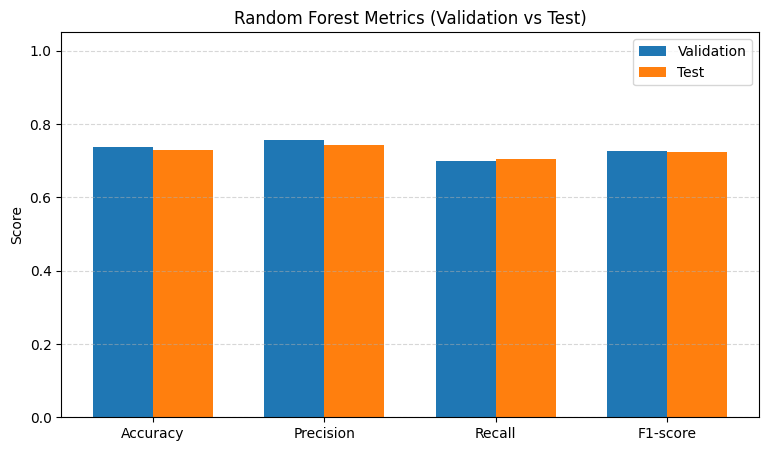

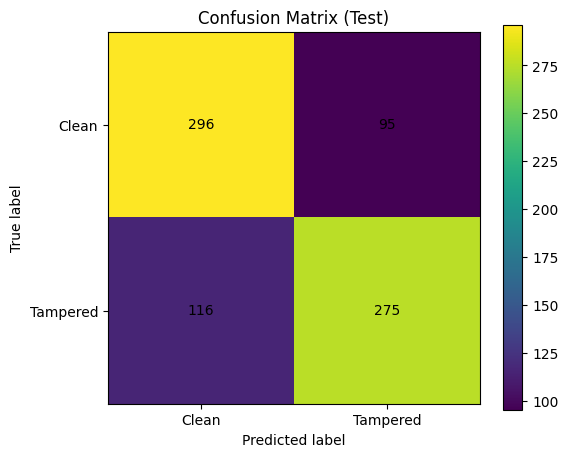


 Saved model: /content/rf_tamper_detector.joblib


In [24]:
!pip install -q scikit-learn scikit-image opencv-python numpy joblib tqdm

import os
import numpy as np
import cv2
import joblib
from glob import glob
from tqdm import tqdm

from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dataset split folder location
TAMPER_SPLIT_DIR = "/content/splits/tamper"

# Some limits for the dataset size
# This just caps how many images the algorithm can use depending on the stage of training
MAX_TRAIN_PER_CLASS = 4000
MAX_VAL_PER_CLASS   = 1500
MAX_TEST_PER_CLASS  = 1500
RANDOM_SEED = 42

RF_PARAMS = {
    "n_estimators": 400,          # Number of trees
    "max_depth": None,            # Means unlimited depth
    "random_state": RANDOM_SEED,
    "class_weight": "balanced",
    "n_jobs": -1                  # This will use all CPU cores for the training
}

# This is a feature extraction function (image into numbers)
# This will turn a image into a 12-value feature vector:
# - Basic stats: mean, min, max, median, std
# - Edge density
# - Blur/detail estimate
# - Shannon entropy
# - Texture features from GLCM: contrast, correlation, energy homoeneity
def extract_features(img_u8: np.ndarray) -> np.ndarray:
    if img_u8.ndim != 2:
        img_u8 = cv2.cvtColor(img_u8, cv2.COLOR_BGR2GRAY)

    mean = float(np.mean(img_u8))
    std = float(np.std(img_u8))
    mn = float(np.min(img_u8))
    mx = float(np.max(img_u8))
    median = float(np.median(img_u8))

    # Detects the edges with Canny
    edges = cv2.Canny(img_u8, 50, 150)
    edge_density = float(np.mean(edges > 0))

    # Uses Laplacian Variance to help detect edits using higher detail/sharpness
    lap_var = float(cv2.Laplacian(img_u8, cv2.CV_64F).var())
    ent = float(shannon_entropy(img_u8))

    # Helps reduce the intensity levels down to around 0-15
    # Then filters into a GLCM (gray-level co-occurrency matrix)
    quant = (img_u8 // 16).astype(np.uint8)
    glcm = graycomatrix(
        quant,
        distances=[1, 2],
        angles=[0, np.pi/4, np.pi/2],
        levels=16,
        symmetric=True,
        normed=True
    )

    # Computes the texture properties across the distances and angles
    contrast = float(graycoprops(glcm, "contrast").mean())
    correlation = float(graycoprops(glcm, "correlation").mean())
    energy = float(graycoprops(glcm, "energy").mean())
    homogeneity = float(graycoprops(glcm, "homogeneity").mean())

    return np.array([
        mean, std, mn, mx, median,
        edge_density, lap_var, ent,
        contrast, correlation, energy, homogeneity
    ], dtype=np.float32)

# Loads train/validation/test splits and balances the clean vs tampered datasets
def sample_list(paths, max_n):
    if len(paths) <= max_n:
        return paths
    rng = np.random.default_rng(RANDOM_SEED)
    idx = rng.choice(len(paths), size=max_n, replace=False)
    return [paths[i] for i in idx]

def get_split(split_name, class_name):
    return sorted(glob(os.path.join(TAMPER_SPLIT_DIR, split_name, class_name, "*.png")))

def build_Xy_progress(clean_paths, tampered_paths, tag=""):
    X, y = [], []

    for p in tqdm(clean_paths, desc=f"{tag} CLEAN feature extraction", unit="img"):
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        X.append(extract_features(img))
        y.append(0)

    for p in tqdm(tampered_paths, desc=f"{tag} TAMPERED feature extraction", unit="img"):
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        X.append(extract_features(img))
        y.append(1)

    return np.array(X), np.array(y)

def load_split(split_name, max_per_class):
    clean = sample_list(get_split(split_name, "clean"), max_per_class)
    tamp  = sample_list(get_split(split_name, "tampered"), max_per_class)

    n = min(len(clean), len(tamp))
    clean, tamp = clean[:n], tamp[:n]

    print(f"\n{split_name.upper()} -> using {len(clean)} clean + {len(tamp)} tampered")
    return build_Xy_progress(clean, tamp, tag=split_name.upper())

X_train, y_train = load_split("train", MAX_TRAIN_PER_CLASS)
X_val, y_val     = load_split("val", MAX_VAL_PER_CLASS)
X_test, y_test   = load_split("test", MAX_TEST_PER_CLASS)

# Trains the Random Forest Model
print("\nTraining RF...")
model = RandomForestClassifier(**RF_PARAMS) # Creates model using the chosen parameters
model.fit(X_train, y_train)                 # Train the model on the extracted features
print("Done.")

# Prints the accuracy, precision, recall, F1-score, and confusion matrix
def eval_split(name, X, y):
    preds = model.predict(X)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y, preds))
    print(classification_report(y, preds, target_names=["Clean", "Tampered"]))
    print("Confusion Matrix:\n", confusion_matrix(y, preds))

eval_split("VALIDATION", X_val, y_val)
eval_split("TEST", X_test, y_test)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# Predict
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Metrics helper
def metrics_dict(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
    }

val_metrics = metrics_dict(y_val, val_preds)
test_metrics = metrics_dict(y_test, test_preds)

print("Validation metrics:", val_metrics)
print("Test metrics:", test_metrics)

# Graph #1: Accuracy / Precision / Recall / F1 (Bar Chart)
labels = list(val_metrics.keys())
val_values = [val_metrics[k] for k in labels]
test_values = [test_metrics[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9, 5))
plt.bar(x - width/2, val_values, width, label="Validation")
plt.bar(x + width/2, test_values, width, label="Test")
plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.title("Random Forest Metrics (Validation vs Test)")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Graph #2: Confusion Matrix (Test)
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Clean", "Tampered"])
plt.yticks([0, 1], ["Clean", "Tampered"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.show()

# Save model
joblib.dump(model, "/content/rf_tamper_detector.joblib")
print("\n Saved model: /content/rf_tamper_detector.joblib")


TRAIN -> using 1824 clean + 1824 tampered


TRAIN TAMPERED feature extraction: 100%|██████████| 1824/1824 [00:16<00:00, 110.19img/s]



VAL -> using 391 clean + 391 tampered


VAL TAMPERED feature extraction: 100%|██████████| 391/391 [00:04<00:00, 96.47img/s] 



TEST -> using 391 clean + 391 tampered


TEST TAMPERED feature extraction: 100%|██████████| 391/391 [00:03<00:00, 114.77img/s]



Training Decision Tree...
Done.

=== VALIDATION ===
Accuracy: 0.6662404092071611
              precision    recall  f1-score   support

       Clean       0.66      0.68      0.67       391
    Tampered       0.67      0.66      0.66       391

    accuracy                           0.67       782
   macro avg       0.67      0.67      0.67       782
weighted avg       0.67      0.67      0.67       782

Confusion Matrix:
 [[264 127]
 [134 257]]

=== TEST ===
Accuracy: 0.6854219948849105
              precision    recall  f1-score   support

       Clean       0.69      0.68      0.68       391
    Tampered       0.68      0.69      0.69       391

    accuracy                           0.69       782
   macro avg       0.69      0.69      0.69       782
weighted avg       0.69      0.69      0.69       782

Confusion Matrix:
 [[267 124]
 [122 269]]

Validation metrics: {'Accuracy': 0.6662404092071611, 'Precision': 0.6692708333333334, 'Recall': 0.6572890025575447, 'F1-score': 0.663225

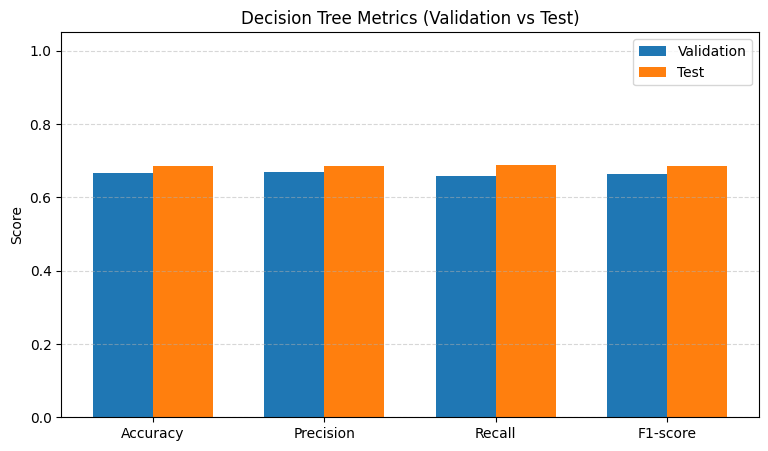

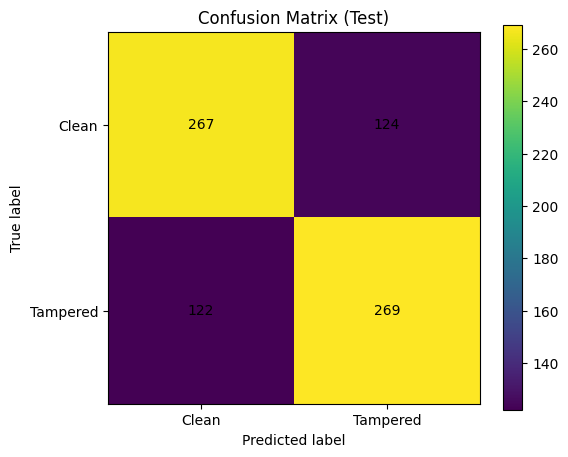


 Saved model: /content/dt_tamper_detector.joblib


In [25]:
!pip install -q scikit-learn scikit-image opencv-python numpy joblib tqdm

import os
import numpy as np
import cv2
import joblib
from glob import glob
from tqdm import tqdm

from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

TAMPER_SPLIT_DIR = "/content/splits/tamper"

# Some limits for the dataset size
# This just caps how many images the algorithm can use depending on the stage of training
MAX_TRAIN_PER_CLASS = 4000
MAX_VAL_PER_CLASS   = 1500
MAX_TEST_PER_CLASS  = 1500
RANDOM_SEED = 42

# Decision Tree parameters (tunable)
DT_PARAMS = {
    "max_depth": None,            # try 10, 15, 20 if overfitting
    "min_samples_split": 2,       # try 5 or 10 for stability
    "min_samples_leaf": 1,        # try 2 or 5 for stability
    "class_weight": "balanced",
    "random_state": RANDOM_SEED
}

# This is a feature extraction function (image into numbers)
# This will turn a image into a 12-value feature vector:
# - Basic stats: mean, min, max, median, std
# - Edge density
# - Blur/detail estimate
# - Shannon entropy
# - Texture features from GLCM: contrast, correlation, energy homoeneity
def extract_features(img_u8: np.ndarray) -> np.ndarray:
    if img_u8.ndim != 2:
        img_u8 = cv2.cvtColor(img_u8, cv2.COLOR_BGR2GRAY)

    mean = float(np.mean(img_u8))
    std = float(np.std(img_u8))
    mn = float(np.min(img_u8))
    mx = float(np.max(img_u8))
    median = float(np.median(img_u8))

    # Detects the edges with Canny
    edges = cv2.Canny(img_u8, 50, 150)
    edge_density = float(np.mean(edges > 0))

    # Uses Laplacian Variance to help detect edits using higher detail/sharpness
    lap_var = float(cv2.Laplacian(img_u8, cv2.CV_64F).var())
    ent = float(shannon_entropy(img_u8))

    # Helps reduce the intensity levels down to around 0-15
    # Then filters into a GLCM (gray-level co-occurrency matrix)
    quant = (img_u8 // 16).astype(np.uint8)
    glcm = graycomatrix(
        quant,
        distances=[1, 2],
        angles=[0, np.pi/4, np.pi/2],
        levels=16,
        symmetric=True,
        normed=True
    )

    # Computes the texture properties across the distances and angles
    contrast = float(graycoprops(glcm, "contrast").mean())
    correlation = float(graycoprops(glcm, "correlation").mean())
    energy = float(graycoprops(glcm, "energy").mean())
    homogeneity = float(graycoprops(glcm, "homogeneity").mean())

    return np.array([
        mean, std, mn, mx, median,
        edge_density, lap_var, ent,
        contrast, correlation, energy, homogeneity
    ], dtype=np.float32)

# Loads train/validation/test splits and balances the clean vs tampered datasets
def sample_list(paths, max_n):
    if len(paths) <= max_n:
        return paths
    rng = np.random.default_rng(RANDOM_SEED)
    idx = rng.choice(len(paths), size=max_n, replace=False)
    return [paths[i] for i in idx]

def get_split(split_name, class_name):
    return sorted(glob(os.path.join(TAMPER_SPLIT_DIR, split_name, class_name, "*.png")))

def build_Xy_progress(clean_paths, tampered_paths, tag=""):
    X, y = [], []

    for p in tqdm(clean_paths, desc=f"{tag} CLEAN feature extraction", unit="img"):
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        X.append(extract_features(img))
        y.append(0)

    for p in tqdm(tampered_paths, desc=f"{tag} TAMPERED feature extraction", unit="img"):
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        X.append(extract_features(img))
        y.append(1)

    return np.array(X), np.array(y)

def load_split(split_name, max_per_class):
    clean = sample_list(get_split(split_name, "clean"), max_per_class)
    tamp  = sample_list(get_split(split_name, "tampered"), max_per_class)

    n = min(len(clean), len(tamp))
    clean, tamp = clean[:n], tamp[:n]

    print(f"\n{split_name.upper()} -> using {len(clean)} clean + {len(tamp)} tampered")
    return build_Xy_progress(clean, tamp, tag=split_name.upper())

X_train, y_train = load_split("train", MAX_TRAIN_PER_CLASS)
X_val, y_val     = load_split("val", MAX_VAL_PER_CLASS)
X_test, y_test   = load_split("test", MAX_TEST_PER_CLASS)

# Train Decision Tree
print("\nTraining Decision Tree...")
model = DecisionTreeClassifier(**DT_PARAMS) # Creates model using the chosen parameters
model.fit(X_train, y_train)                 # Train the model on the extracted features
print("Done.")

# Prints the accuracy, precision, recall, F1-score, and confusion matrix
def eval_split(name, X, y):
    preds = model.predict(X)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y, preds))
    print(classification_report(y, preds, target_names=["Clean", "Tampered"]))
    print("Confusion Matrix:\n", confusion_matrix(y, preds))

eval_split("VALIDATION", X_val, y_val)
eval_split("TEST", X_test, y_test)

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

def metrics_dict(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
    }

val_metrics = metrics_dict(y_val, val_preds)
test_metrics = metrics_dict(y_test, test_preds)

print("\nValidation metrics:", val_metrics)
print("Test metrics:", test_metrics)

# Graph #1: Metrics bar chart
labels = list(val_metrics.keys())
val_values = [val_metrics[k] for k in labels]
test_values = [test_metrics[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9, 5))
plt.bar(x - width/2, val_values, width, label="Validation")
plt.bar(x + width/2, test_values, width, label="Test")
plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.title("Decision Tree Metrics (Validation vs Test)")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Graph #2: Confusion matrix
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Clean", "Tampered"])
plt.yticks([0, 1], ["Clean", "Tampered"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.show()

# Save model
joblib.dump(model, "/content/dt_tamper_detector.joblib")
print("\n Saved model: /content/dt_tamper_detector.joblib")



TRAIN -> using 1824 clean + 1824 tampered


TRAIN TAMPERED feature extraction: 100%|██████████| 1824/1824 [00:16<00:00, 109.27img/s]



VAL -> using 391 clean + 391 tampered


VAL TAMPERED feature extraction: 100%|██████████| 391/391 [00:04<00:00, 93.82img/s] 



TEST -> using 391 clean + 391 tampered


TEST TAMPERED feature extraction: 100%|██████████| 391/391 [00:03<00:00, 114.43img/s]



Training KNN...
Done.

=== VALIDATION ===
Accuracy: 0.6432225063938619
              precision    recall  f1-score   support

       Clean       0.62      0.75      0.68       391
    Tampered       0.68      0.53      0.60       391

    accuracy                           0.64       782
   macro avg       0.65      0.64      0.64       782
weighted avg       0.65      0.64      0.64       782

Confusion Matrix:
 [[294  97]
 [182 209]]

=== TEST ===
Accuracy: 0.6329923273657289
              precision    recall  f1-score   support

       Clean       0.61      0.75      0.67       391
    Tampered       0.67      0.52      0.58       391

    accuracy                           0.63       782
   macro avg       0.64      0.63      0.63       782
weighted avg       0.64      0.63      0.63       782

Confusion Matrix:
 [[293  98]
 [189 202]]

Validation metrics: {'Accuracy': 0.6432225063938619, 'Precision': 0.6830065359477124, 'Recall': 0.5345268542199488, 'F1-score': 0.599713055954089}

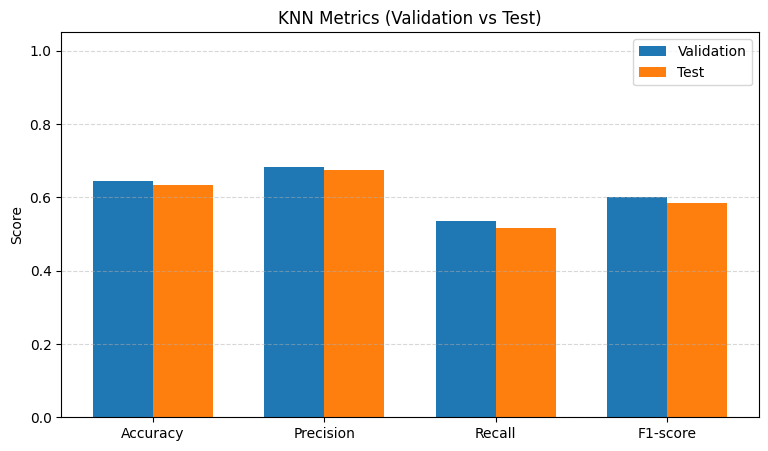

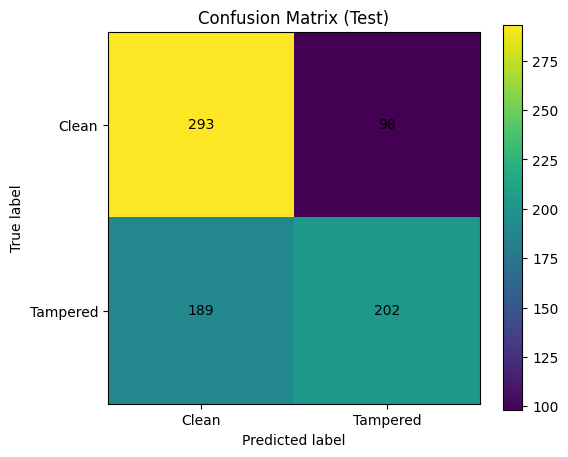


Saved model: /content/knn_tamper_detector.joblib


In [26]:
!pip install -q scikit-learn scikit-image opencv-python numpy joblib tqdm

import os
import numpy as np
import cv2
import joblib
from glob import glob
from tqdm import tqdm

from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dataset split folder location
TAMPER_SPLIT_DIR = "/content/splits/tamper"

# Some limits for the dataset size
# This just caps how many images the algorithm can use depending on the stage of training
MAX_TRAIN_PER_CLASS = 4000
MAX_VAL_PER_CLASS   = 1500
MAX_TEST_PER_CLASS  = 1500
RANDOM_SEED = 42

# KNN parameters (tunable)
KNN_PARAMS = {
    "n_neighbors": 7,        # could use: 3, 5, 7, 9, 11
    "weights": "distance",   # "uniform" or "distance"
    "metric": "minkowski",   # default Euclidean (p=2)
    "p": 2
}

# This is a feature extraction function (image into numbers)
# This will turn a image into a 12-value feature vector:
# - Basic stats: mean, min, max, median, std
# - Edge density
# - Blur/detail estimate
# - Shannon entropy
# - Texture features from GLCM: contrast, correlation, energy homoeneity
def extract_features(img_u8: np.ndarray) -> np.ndarray:
    if img_u8.ndim != 2:
        img_u8 = cv2.cvtColor(img_u8, cv2.COLOR_BGR2GRAY)

    mean = float(np.mean(img_u8))
    std = float(np.std(img_u8))
    mn = float(np.min(img_u8))
    mx = float(np.max(img_u8))
    median = float(np.median(img_u8))

    # Detects the edges with Canny
    edges = cv2.Canny(img_u8, 50, 150)
    edge_density = float(np.mean(edges > 0))

    # Uses Laplacian Variance to help detect edits using higher detail/sharpness
    lap_var = float(cv2.Laplacian(img_u8, cv2.CV_64F).var())
    ent = float(shannon_entropy(img_u8))

    # Helps reduce the intensity levels down to around 0-15
    # Then filters into a GLCM (gray-level co-occurrency matrix)
    quant = (img_u8 // 16).astype(np.uint8)
    glcm = graycomatrix(
        quant,
        distances=[1, 2],
        angles=[0, np.pi/4, np.pi/2],
        levels=16,
        symmetric=True,
        normed=True
    )

    # Computes the texture properties across the distances and angles
    contrast = float(graycoprops(glcm, "contrast").mean())
    correlation = float(graycoprops(glcm, "correlation").mean())
    energy = float(graycoprops(glcm, "energy").mean())
    homogeneity = float(graycoprops(glcm, "homogeneity").mean())

    return np.array([
        mean, std, mn, mx, median,
        edge_density, lap_var, ent,
        contrast, correlation, energy, homogeneity
    ], dtype=np.float32)

# Loads train/validation/test splits and balances the clean vs tampered datasets
def sample_list(paths, max_n):
    if len(paths) <= max_n:
        return paths
    rng = np.random.default_rng(RANDOM_SEED)
    idx = rng.choice(len(paths), size=max_n, replace=False)
    return [paths[i] for i in idx]

def get_split(split_name, class_name):
    return sorted(glob(os.path.join(TAMPER_SPLIT_DIR, split_name, class_name, "*.png")))

def build_Xy_progress(clean_paths, tampered_paths, tag=""):
    X, y = [], []

    for p in tqdm(clean_paths, desc=f"{tag} CLEAN feature extraction", unit="img"):
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        X.append(extract_features(img))
        y.append(0)

    for p in tqdm(tampered_paths, desc=f"{tag} TAMPERED feature extraction", unit="img"):
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        X.append(extract_features(img))
        y.append(1)

    return np.array(X), np.array(y)

def load_split(split_name, max_per_class):
    clean = sample_list(get_split(split_name, "clean"), max_per_class)
    tamp  = sample_list(get_split(split_name, "tampered"), max_per_class)

    n = min(len(clean), len(tamp))
    clean, tamp = clean[:n], tamp[:n]

    print(f"\n{split_name.upper()} -> using {len(clean)} clean + {len(tamp)} tampered")
    return build_Xy_progress(clean, tamp, tag=split_name.upper())

X_train, y_train = load_split("train", MAX_TRAIN_PER_CLASS)
X_val, y_val     = load_split("val", MAX_VAL_PER_CLASS)
X_test, y_test   = load_split("test", MAX_TEST_PER_CLASS)

# Train KNN (with feature scaling)
print("\nTraining KNN...")
model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(**KNN_PARAMS))  # Creates model using the chosen parameters
])

model.fit(X_train, y_train) # Train the model on the extracted features
print("Done.")

# Prints the accuracy, precision, recall, F1-score, and confusion matrix
def eval_split(name, X, y):
    preds = model.predict(X)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y, preds))
    print(classification_report(y, preds, target_names=["Clean", "Tampered"]))
    print("Confusion Matrix:\n", confusion_matrix(y, preds))

eval_split("VALIDATION", X_val, y_val)
eval_split("TEST", X_test, y_test)

# Graphs: Metrics + Confusion matrix (separate)
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

def metrics_dict(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
    }

val_metrics = metrics_dict(y_val, val_preds)
test_metrics = metrics_dict(y_test, test_preds)

print("\nValidation metrics:", val_metrics)
print("Test metrics:", test_metrics)

# Graph #1: Accuracy / Precision / Recall / F1 (Bar Chart)
labels = list(val_metrics.keys())
val_values = [val_metrics[k] for k in labels]
test_values = [test_metrics[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9, 5))
plt.bar(x - width/2, val_values, width, label="Validation")
plt.bar(x + width/2, test_values, width, label="Test")
plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.title("KNN Metrics (Validation vs Test)")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Graph #2: Confusion Matrix (Test)
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Clean", "Tampered"])
plt.yticks([0, 1], ["Clean", "Tampered"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.show()

# Save model
joblib.dump(model, "/content/knn_tamper_detector.joblib")
print("\nSaved model: /content/knn_tamper_detector.joblib")
